# "Quantiles of Mixture Distributions"
> "How to efficiently compute quantiles of mixture distributions, with examples."

- toc: true
- branch: master
- badges: false
- comments: false
- categories: [probability]
- hide: false
- search_exclude: false
- image: images/blog_posts/mixture_distributions.png
- redirect_from: blog/quantiles_of

How do you compute quantiles of mixture distributions? I had to do this for a project recently, and Googling didn't lead me to a nice, easy answer. This is a quick summary of a (fairly obvious) solution to that problem, in the hope that it will save somebody some time.

## Mixture distributions

Suppose we have $N$ random variables, with the $i$th random variable $X_i$ having the probability density function $f_i(x)$ and the cumulative distribution function $F_i(x)$. Now suppose we select one of the random variables randomly, with random variable $i$ having a probability $p_i$ of being selected. The probability distribution of the randomly selected variable is a mixture distribution. 

## The PDF and CDF of a mixture distribution

We can write the pdf $f(x)$ and cdf $F(x)$ of the mixture distribution as follows.

$f(x) = \sum_{i=1}^{N} p_i f_i(x)\quad$, and

$F(x) = \sum_{i=1}^{N} p_i F_i(x)\quad$.

In words, the the mixture distribution pdf (and cdf) is a weighted sum of the component distribution pdfs (and cdfs), weighted by the probability with which the corresponding random variables are selected.

For example, suppose we flip a fair coin, and if it comes up heads we sample from an exponential distribution (with scale 1), and if it comes up tails we sample from a standard normal distribution. The following plots show the component distribution and mixture distribution pdfs.

In [2]:
#hide
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

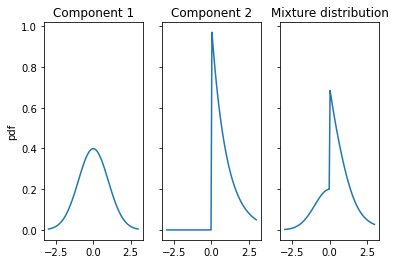

In [3]:
xs = np.linspace(-3, 3, 100)
ps_component1 = stats.norm().pdf(xs)
ps_component2 = stats.expon().pdf(xs)
ps_mixture = 0.5 * ps_component1 + 0.5 * ps_component2

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.plot(xs, ps_component1)
ax1.set_title('Component 1')
ax2.plot(xs, ps_component2)
ax2.set_title('Component 2')
ax3.plot(xs, ps_mixture)
ax3.set_title('Mixture distribution')
ax1.set_ylabel('pdf');

## Computing quantiles of mixture distributions (of continuous component distributions)

Unfortunately, there's no way, in general, of expressing the quantile function of a mixture distribution in terms of the quantile functions of the component distributions. So what do we do if we need to compute the $p$th quantile of a mixture?

We look for the smallest value $x$ such that the cdf $F(x)$ is greater than or equal to $p$. As noted above, we can calculate $F(x)$ in terms of the cdfs of the components. Because $F(x)$ is monotonically increasing, we can perform binary search on $x$ to find the smallest value such that $F(x)$ is greater than or equal to $p$. 

First we'll need the following function. It returns the smallest value $x$ between $lo$ and $hi$ such that $f(x) \ge v$.

In [3]:
# Return the smallest value x between lo and hi such that f(x) >= v
def continuous_bisect_fun_left(f, v, lo, hi):
    val_range = [lo, hi]
    k = 0.5 * sum(val_range)
    for i in range(32):
        val_range[int(f(k) > v)] = k
        next_k = 0.5 * sum(val_range)
        if next_k == k:
            break
        k = next_k
    return k

The following function takes a list of component distributions and a list of probabilities, and returns the a function which is the cdf of the mixture.

In [4]:
# Return the function that is the cdf of the mixture distribution
def get_mixture_cdf(component_distributions, ps):
    return lambda x: sum(component_dist.cdf(x) * p for component_dist, p in zip(component_distributions, ps))

The following function puts these together to compute the $p$th quantile of the mixture.

In [5]:
# Return the pth quantile of the mixture distribution given by the component distributions and their probabilities
def mixture_quantile(p, component_distributions, ps):
    mixture_cdf = get_mixture_cdf(component_distributions, ps)

    # We can probably be a bit smarter about how we pick the limits
    lo = np.min([dist.ppf(p) for dist in component_distributions])
    hi = np.max([dist.ppf(p) for dist in component_distributions])

    return continuous_bisect_fun_left(mixture_cdf, p, lo, hi)

Let's test it by finding the 75th percentile of the mixture of a normal and exponential distribution described above.

In [6]:
# The two component distributions: a normal and an exponential distribution
component_dists = [stats.norm(), stats.expon()]
# Chosen by fair coin flip
ps = [0.5, 0.5]
# We want the 75th percentile of the mixture
p = 0.75

quantile = mixture_quantile(p, component_dists, ps)
print("Computed quantile for p = 0.75: {}".format(quantile))

Computed quantile for p = 0.75: 1.0444910285011346


Now let's calculate the same thing by sampling.

In [8]:
N = 200000
# Determine how many of our samples are from the normal distribution,
# and how many from the exponential distribution, based on a fair coin flip
num_normal = np.random.binomial(N, 0.5)
num_exponential = N - num_normal

# Gather our normal and exponential samples
normal_samples = np.random.normal(size=num_normal)
expon_samples = np.random.exponential(size=num_exponential)

# Pool the samples
samples = np.hstack((normal_samples, expon_samples))

sample_quantile = np.percentile(samples, p*100)
print("Quantile from sample for p = 0.75: {}".format(sample_quantile))

Quantile from sample for p = 0.75: 1.0441686918008217


Voila.

You can do the same thing if you have a mixture of discrete distributions by using the python built-in function bisect.bisect_left (in place of my continuous_bisect_fun_left function) on a lazily evaluated array (using the la module) of the mixture CDF values.